<a href="https://colab.research.google.com/github/duwi27sulis/Analisis_Data_LSTM/blob/main/Update_H2_T3_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.1 MB/s eta 0:00:00


In [19]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [20]:
# Fix random seed for reproducibility
tf.random.set_seed(42)
plt.rcParams['figure.figsize'] = (12,6)

In [21]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
data = df['Nilai Ekspor Migas'].values.astype('float32').reshape(-1, 1)

In [22]:
# Statistik Deskriptif
df['Nilai Ekspor Migas'].describe()

,Nilai Ekspor Migas
count,276.000000
mean,1676.342029
std,768.702279
min,560.900000
25%,1122.675000
50%,1422.750000
75%,2101.000000
max,4091.600000


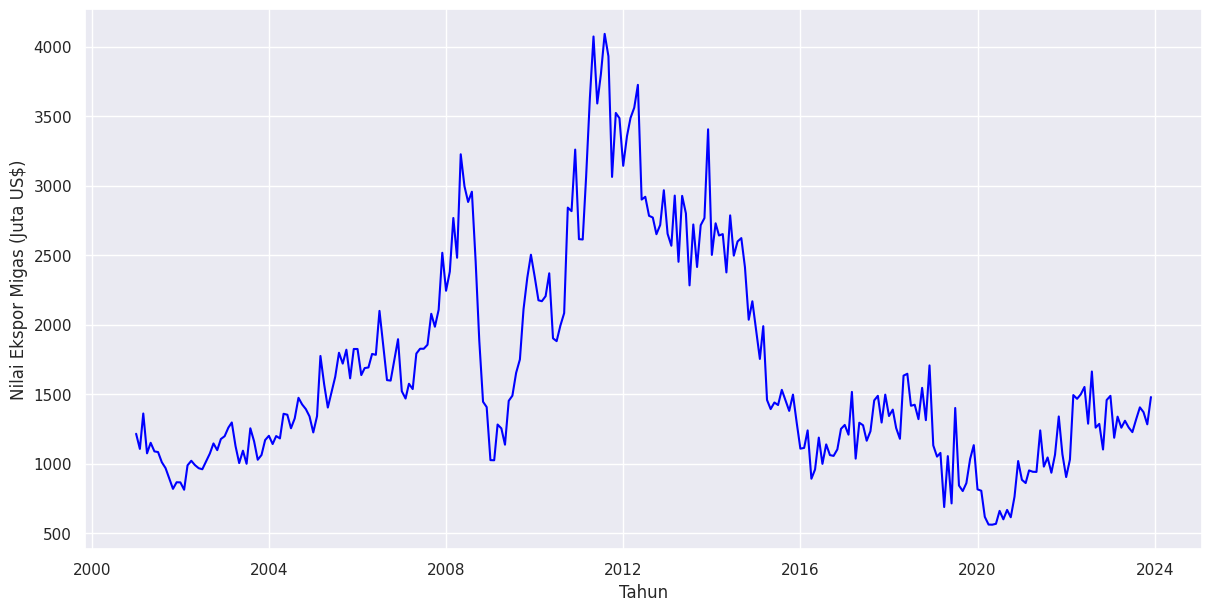

In [23]:
# Line plot data time series
from matplotlib import pyplot as plt
import seaborn as sns

def _plot_series(series, series_name, series_index=0):
    xs = series['Tanggal']
    ys = series['Nilai Ekspor Migas']

    plt.plot(xs, ys, label=series_name, color='blue')

fig, ax = plt.subplots(figsize=(12, 6), layout='constrained')
df_sorted = df.sort_values('Tanggal', ascending=True)
_plot_series(df_sorted, '')

# Menambahkan bingkai kotak
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

sns.despine(fig=fig, ax=ax, top=False, right=False, bottom=False, left=False)
plt.xlabel('Tahun')
_ = plt.ylabel('Nilai Ekspor Migas (Juta US$)')

plt.show()

In [24]:
# Uji kestasioneran (Augmented Dickey-Fuller Test)
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

result_original = sm.tsa.adfuller(data)
print('ADF Statistic :', result_original[0])
print('p-value :', result_original[1])
print('Critical :')
for key, value in result_original[4].items():
    print(f'   {key}: {value}')

ADF Statistic : -2.0481781387920948
p-value : 0.2658560561741424
Critical :
   1%: -3.4544435065994437
   5%: -2.8721468827772774
   10%: -2.572422013959188


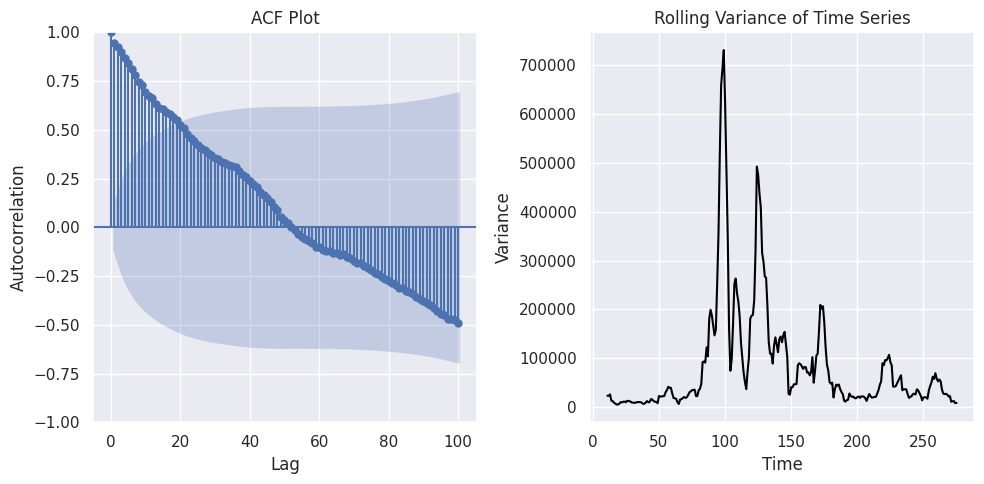

In [25]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# Mengatur gaya seaborn
sns.set()

# Mengambil kolom 'Nilai Ekspor Migas' sebagai series
series = df['Nilai Ekspor Migas']

# Membuat ACF Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_acf(series, ax=ax[0], lags=100)
ax[0].set_title('ACF Plot')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

# Menghitung varians bergulir dengan window size 12 (misal: bulanan untuk data tahunan)
rolling_variance = series.rolling(window=12).var()

# Membuat plot rolling variance
ax[1].plot(rolling_variance, color='black')
ax[1].set_title('Rolling Variance of Time Series')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [26]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [27]:
# Fungsi untuk membuat dataset
def create_dataset(dataset, time_steps=3):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps), 0])
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

In [28]:
# Prepare data
time_steps = 3
X, y = create_dataset(scaled_data, time_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [30]:
# Split data into training and testing sets
train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size, :], X[train_size:, :]
y_train, y_test = y[:train_size], y[train_size:]

print(X_train.shape, X_test.shape, sep='\n')

(232, 3, 1)
(41, 3, 1)


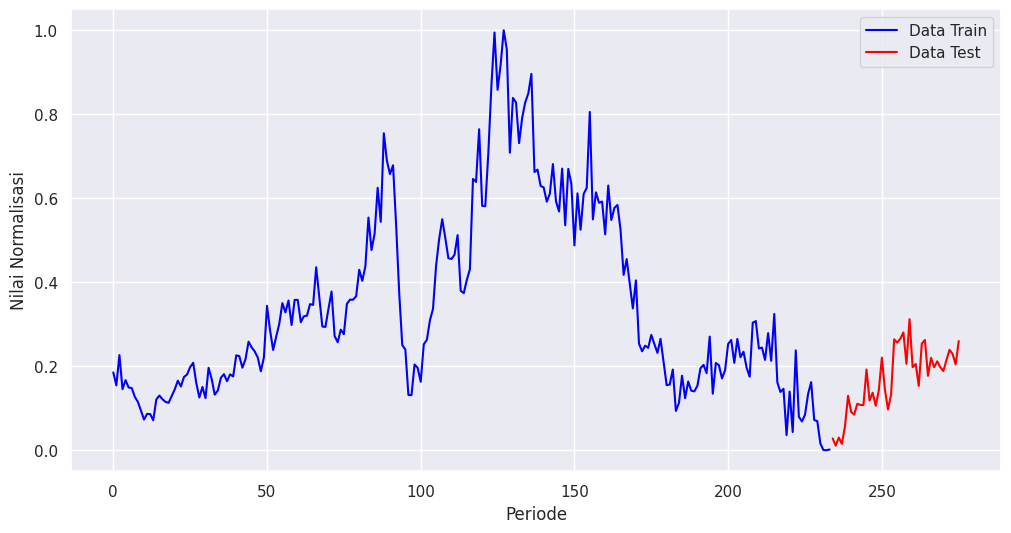

In [31]:
plt.figure(figsize=(12, 6))

bagi_train = int(len(scaled_data)*0.85)
bagi_test = len(scaled_data) - bagi_train
Xnorm_train, Xnorm_test = scaled_data[:bagi_train, :], scaled_data[bagi_train:, :]

# Plot X_train setelah normalisasi
plt.plot(range(len(Xnorm_train)), Xnorm_train, color='blue', label='Data Train')

# Plot X_test setelah normalisasi (dimulai dari akhir X_train)
plt.plot(range(len(Xnorm_train), len(Xnorm_train) + len(Xnorm_test)), Xnorm_test, color='red', label='Data Test')

# Menambahkan label dan legenda
plt.xlabel('Periode')
plt.ylabel('Nilai Normalisasi')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

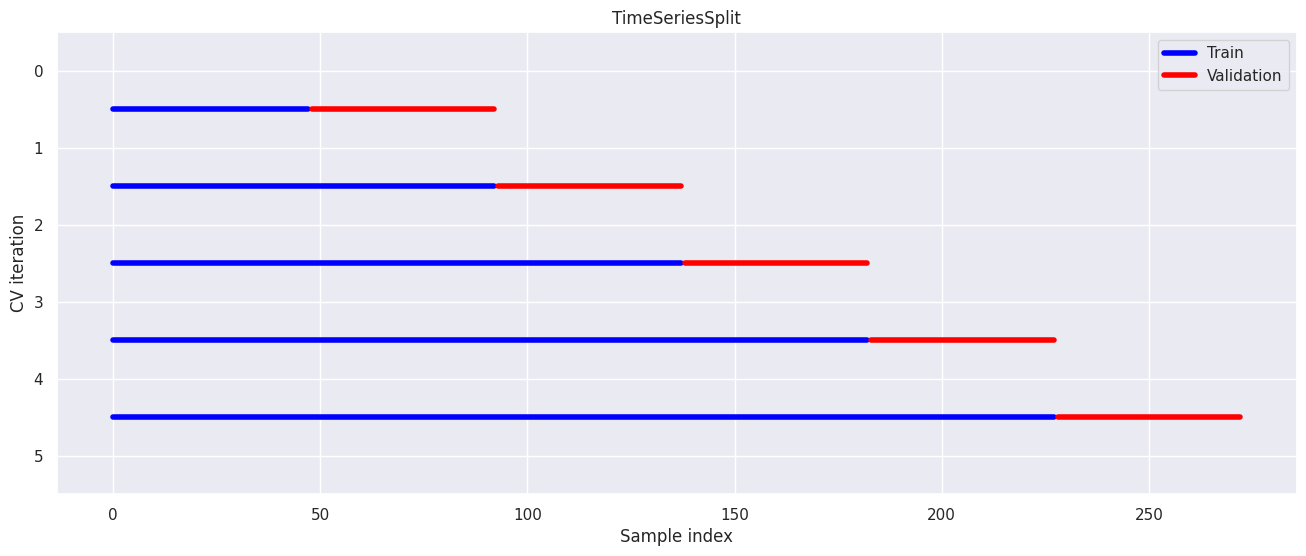

In [33]:
# Visualisasi TimeSeriesSplit
def plot_time_series_cv(tscv, X):
    plt.figure(figsize=(16, 6))
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        indices = np.arange(len(X))
        plt.plot(indices[train_index], [i + 0.5] * len(train_index), color = 'blue', linewidth = '4.0', label='Train' if i == 0 else '')
        plt.plot(indices[test_index], [i + 0.5] * len(test_index), color = 'red', linewidth = '4.0', label='Validation' if i == 0 else '')
    plt.ylim(-0.5, tscv.get_n_splits(X) + 0.5)
    plt.title('TimeSeriesSplit')
    plt.xlabel('Sample index')
    plt.ylabel('CV iteration')
    plt.legend(loc='best')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the smallest CV iteration at the top
    plt.show()

# Plot the TimeSeriesSplit
plot_time_series_cv(tscv, X)

In [34]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [35]:
def objective(trial):
    # Define the search space
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [32, 64, 128])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [32, 64, 128])
    dropout_rate_1 = trial.suggest_categorical('dropout_rate_1', [0.1, 0.2, 0.3, 0.4, 0.5])
    dropout_rate_2 = trial.suggest_categorical('dropout_rate_2', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model with 2 hidden layers
        model = Sequential([
            LSTM(units=lstm_units_1, return_sequences=True, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate_1),
            LSTM(units=lstm_units_2),
            Dropout(dropout_rate_2),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

    return np.mean(cv_scores)

In [36]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-15 10:38:37,973] A new study created in memory with name: no-name-0dd02977-602f-4321-ac35-ce623a92a17c


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


[I 2024-08-15 10:39:56,054] Trial 0 finished with value: 0.020923618227243423 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 200, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.020923618227243423.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 10:40:53,722] Trial 1 finished with value: 0.0632670521736145 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.020923618227243423.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step


[I 2024-08-15 10:42:01,959] Trial 2 finished with value: 0.0981658324599266 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.020923618227243423.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 452ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 10:42:35,083] Trial 3 finished with value: 0.0775526762008667 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.2, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.020923618227243423.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 10:43:24,565] Trial 4 finished with value: 0.011976618319749832 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.011976618319749832.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step


[I 2024-08-15 10:43:59,946] Trial 5 finished with value: 0.01527715940028429 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.011976618319749832.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 396ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step


[I 2024-08-15 10:44:44,988] Trial 6 finished with value: 0.012096351012587547 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.011976618319749832.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step


[I 2024-08-15 10:45:27,925] Trial 7 finished with value: 0.013635423965752125 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.011976618319749832.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step


[I 2024-08-15 10:46:13,031] Trial 8 finished with value: 0.05457409471273422 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 4 with value: 0.011976618319749832.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 10:46:55,877] Trial 9 finished with value: 0.008694467134773731 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.008694467134773731.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step


[I 2024-08-15 10:47:43,990] Trial 10 finished with value: 0.006090479902923107 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.006090479902923107.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step


[I 2024-08-15 10:48:28,770] Trial 11 finished with value: 0.006955253891646862 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.006090479902923107.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 421ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2024-08-15 10:49:16,843] Trial 12 finished with value: 0.0064987377263605595 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 10 with value: 0.006090479902923107.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 379ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 424ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 10:50:13,416] Trial 13 finished with value: 0.005991525948047638 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step


[I 2024-08-15 10:51:01,926] Trial 14 finished with value: 0.0066178119741380215 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


[I 2024-08-15 10:51:52,631] Trial 15 finished with value: 0.006777794566005468 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step


[I 2024-08-15 10:52:42,234] Trial 16 finished with value: 0.0062759690918028355 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 311ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


[I 2024-08-15 10:53:33,532] Trial 17 finished with value: 0.011737795546650887 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step


[I 2024-08-15 10:54:12,101] Trial 18 finished with value: 0.023471098393201828 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step


[I 2024-08-15 10:54:45,438] Trial 19 finished with value: 0.007913770154118538 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 10:55:27,238] Trial 20 finished with value: 0.010757354088127613 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 10:56:17,644] Trial 21 finished with value: 0.006218812428414822 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 434ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


[I 2024-08-15 10:57:06,957] Trial 22 finished with value: 0.006879081483930349 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 313ms/step


[I 2024-08-15 10:57:56,508] Trial 23 finished with value: 0.00646480405703187 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step


[I 2024-08-15 10:58:43,802] Trial 24 finished with value: 0.00639351736754179 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step


[I 2024-08-15 10:59:39,656] Trial 25 finished with value: 0.02306511625647545 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


[I 2024-08-15 11:00:24,728] Trial 26 finished with value: 0.006523381918668747 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 11:01:10,291] Trial 27 finished with value: 0.006234536878764629 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 412ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


[I 2024-08-15 11:01:49,368] Trial 28 finished with value: 0.007543692830950022 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 359ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 11:02:33,213] Trial 29 finished with value: 0.019499901682138443 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 200, 'optimizer': 'RMSprop'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 423ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step


[I 2024-08-15 11:03:25,021] Trial 30 finished with value: 0.05881815403699875 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout_rate_1': 0.4, 'dropout_rate_2': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 11:04:12,621] Trial 31 finished with value: 0.006077255122363567 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 13 with value: 0.005991525948047638.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step


[I 2024-08-15 11:04:57,009] Trial 32 finished with value: 0.005821326747536659 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 11:05:44,455] Trial 33 finished with value: 0.006119060330092907 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 472ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step


[I 2024-08-15 11:06:51,165] Trial 34 finished with value: 0.06187869980931282 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 352ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step


[I 2024-08-15 11:07:44,886] Trial 35 finished with value: 0.007599896751344204 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 11:08:34,129] Trial 36 finished with value: 0.007200653664767742 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step


[I 2024-08-15 11:09:18,163] Trial 37 finished with value: 0.05921649932861328 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step


[I 2024-08-15 11:09:52,542] Trial 38 finished with value: 0.012334929779171944 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


[I 2024-08-15 11:10:28,070] Trial 39 finished with value: 0.012303365394473076 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 414ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2024-08-15 11:11:06,876] Trial 40 finished with value: 0.008334018290042877 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.3, 'dropout_rate_2': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step


[I 2024-08-15 11:12:01,489] Trial 41 finished with value: 0.006174019537866116 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


[I 2024-08-15 11:12:53,121] Trial 42 finished with value: 0.005924699828028679 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 438ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 362ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step


[I 2024-08-15 11:13:42,392] Trial 43 finished with value: 0.007001594640314579 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 408ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


[I 2024-08-15 11:14:33,550] Trial 44 finished with value: 0.006633995566517115 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 385ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2024-08-15 11:15:23,095] Trial 45 finished with value: 0.06058346480131149 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step


[I 2024-08-15 11:16:13,150] Trial 46 finished with value: 0.006422087550163269 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step


[I 2024-08-15 11:16:54,382] Trial 47 finished with value: 0.011439395137131214 and parameters: {'lstm_units_1': 32, 'lstm_units_2': 32, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step


[I 2024-08-15 11:17:37,340] Trial 48 finished with value: 0.007069788873195648 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 32 with value: 0.005821326747536659.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step


[I 2024-08-15 11:18:25,415] Trial 49 finished with value: 0.025320526212453842 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 128, 'dropout_rate_1': 0.5, 'dropout_rate_2': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 32 with value: 0.005821326747536659.


Best parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}
Best value: 0.005821326747536659


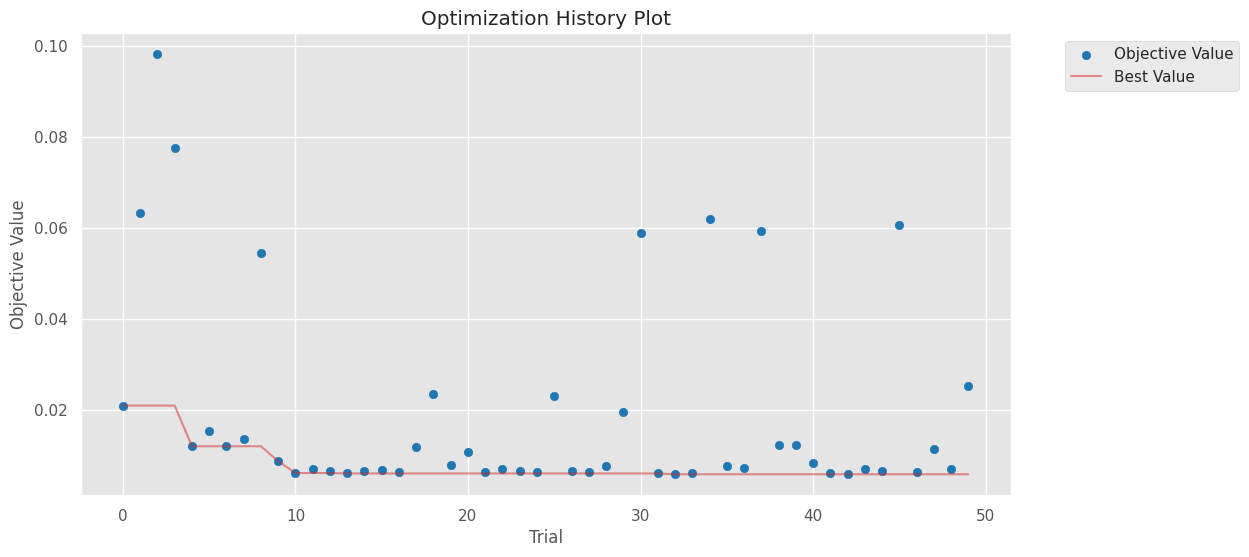

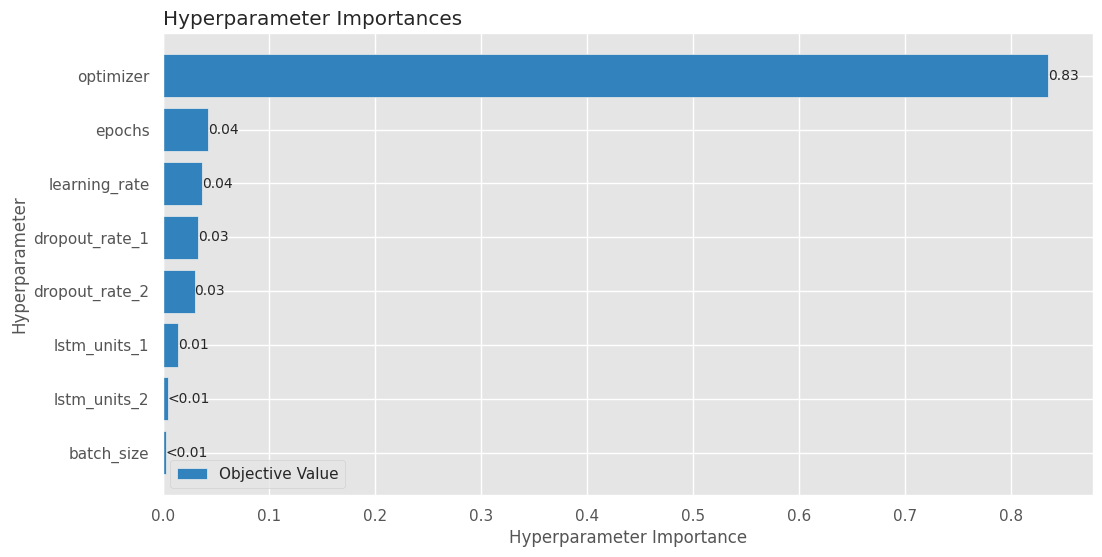

In [37]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [38]:
# Train final model with best parameters
best_params = study.best_params
model =  Sequential([
    LSTM(units=best_params['lstm_units_1'], return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate_1']),
    LSTM(units=best_params['lstm_units_2']),
    Dropout(best_params['dropout_rate_2']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.1342 - val_loss: 0.0047
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0249 - val_loss: 0.0038
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0130 - val_loss: 0.0038
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0141 - val_loss: 0.0044
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0121 - val_loss: 0.0035
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0112 - val_loss: 0.0044
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0097 - val_loss: 0.0036
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0128 - val_loss: 0.0038
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0089 - val_loss: 0.0044
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0098 - val_loss: 0.0035
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0092 - val_lo

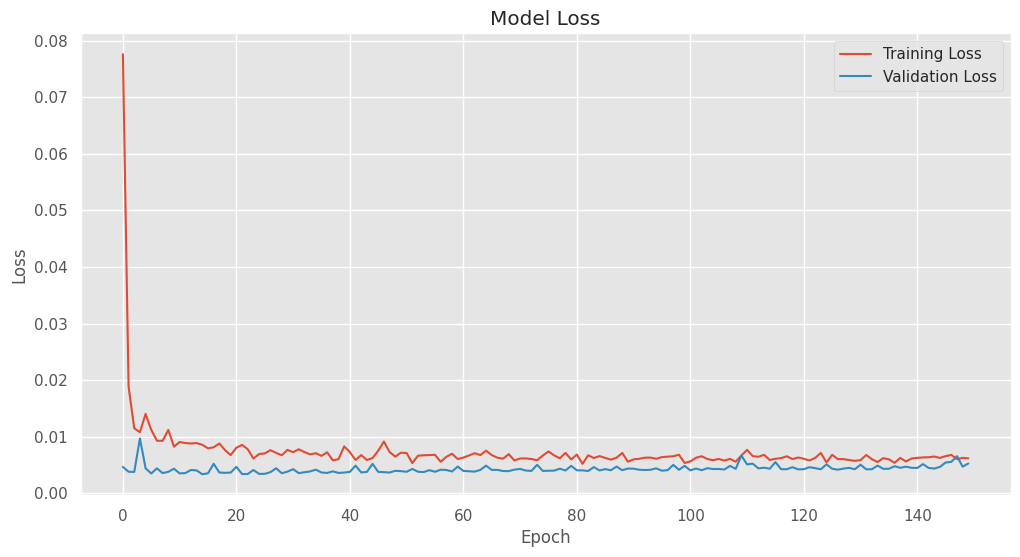

Average Loss: 0.0074


In [39]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [40]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [41]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [42]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [43]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 195.439
Root Mean Square Error: 263.789
Mean Absolute Percentage Error: 12.249%

evaluasi model data test:
Mean Absolute Error: 144.997
Root Mean Square Error: 185.585
Mean Absolute Percentage Error: 13.287%



In [46]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

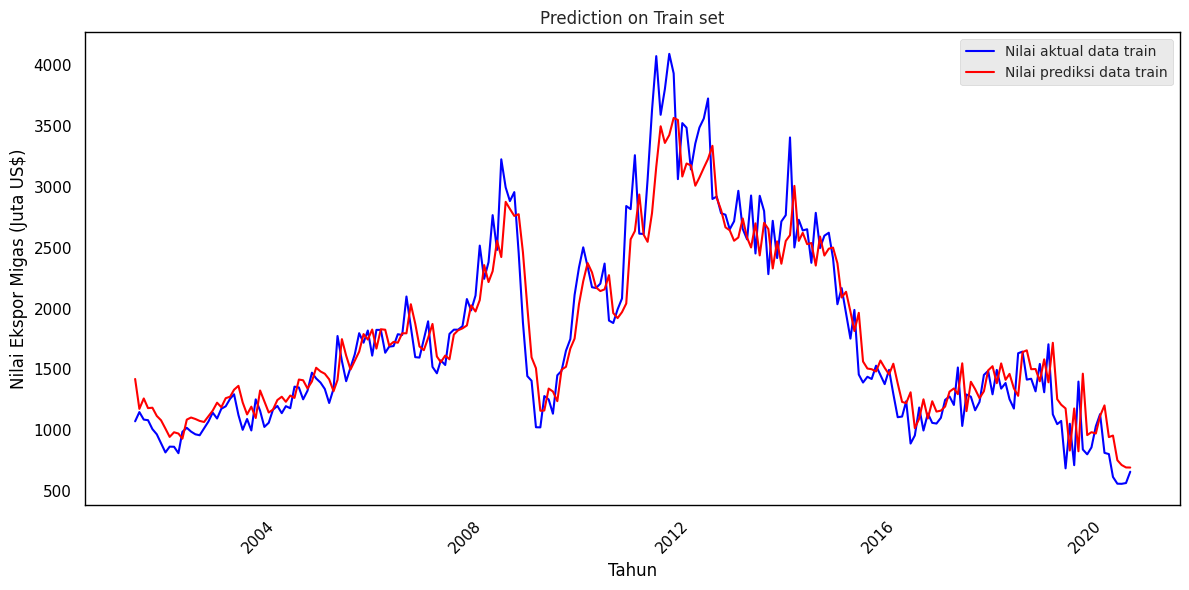

In [47]:
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

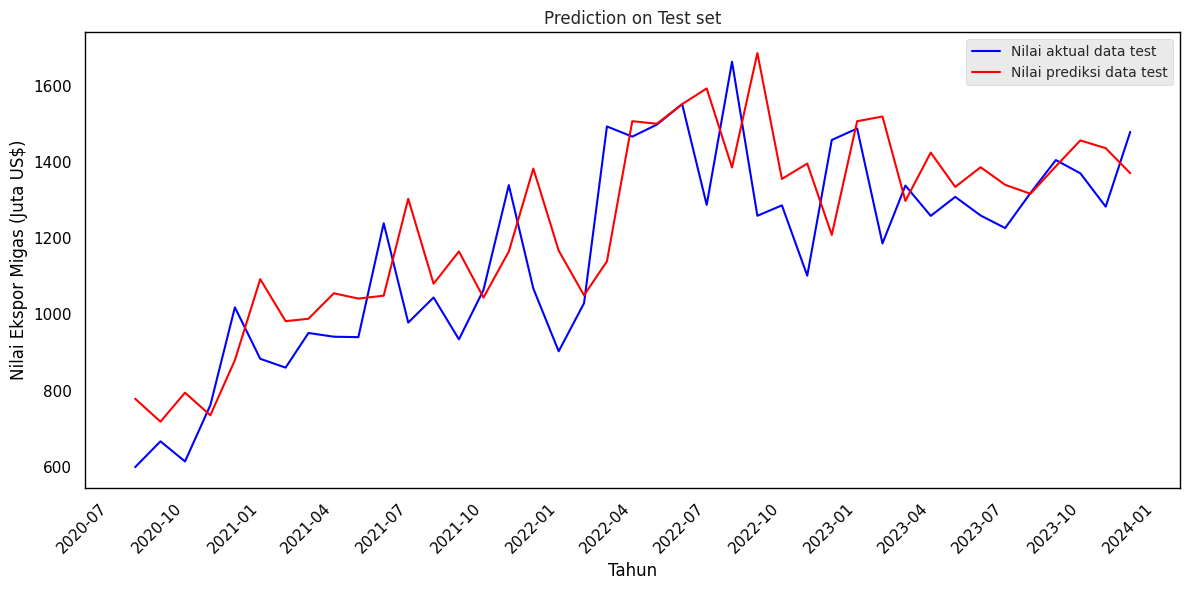

In [48]:
import matplotlib.dates as mdates

# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

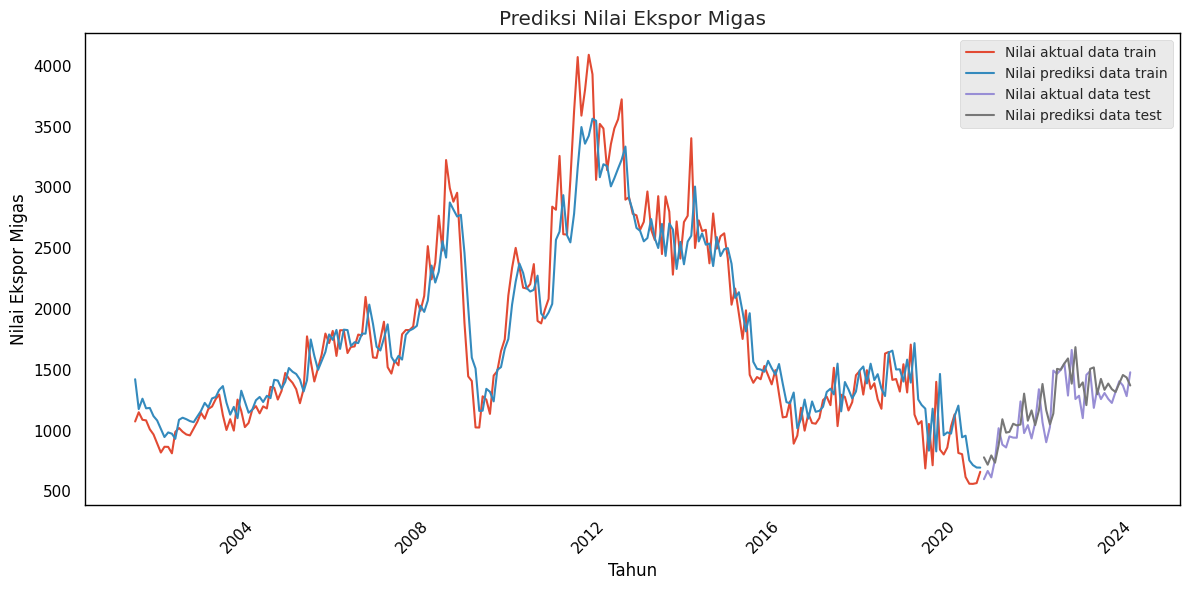

In [49]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1526.673950
1  2024-02-01                     1561.134644
2  2024-03-01                     1601.985474
3  2024-04-01                     1638.072998
4  2024-05-01                     1669.685547
5  2024-06-01                     1698.020996
6  2024-07-01                     1723.317017
7  2024-08-01                     1745.834351
8  2024-09-01                     1765.869019
9  2024-10-01                     1783.682007
10 2024-11-01                     1799

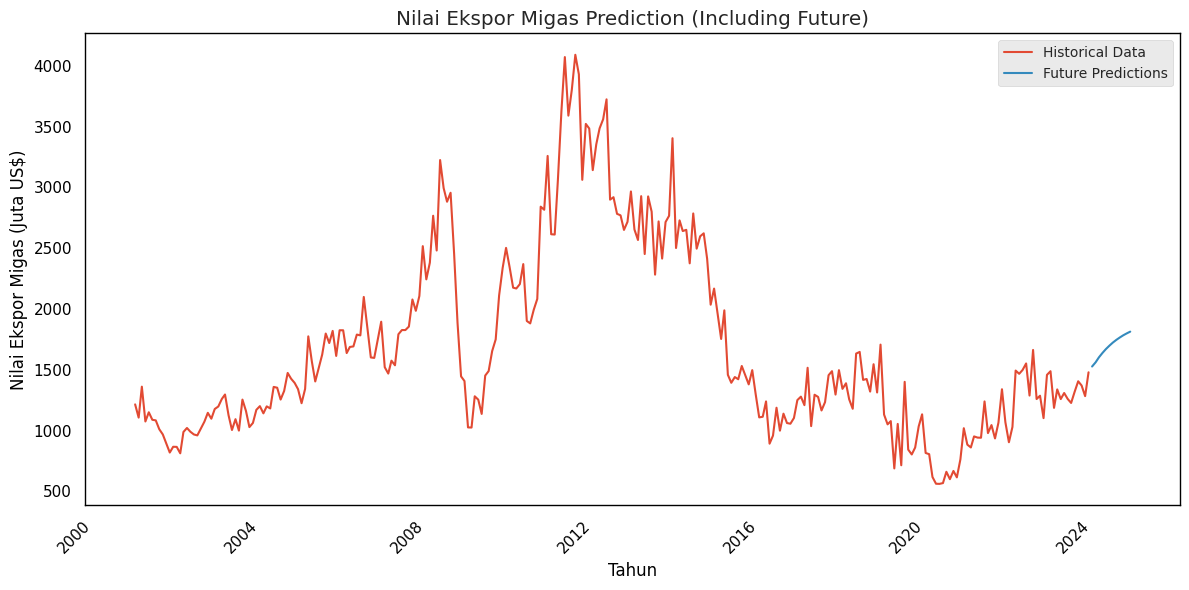

In [50]:
# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_data[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()

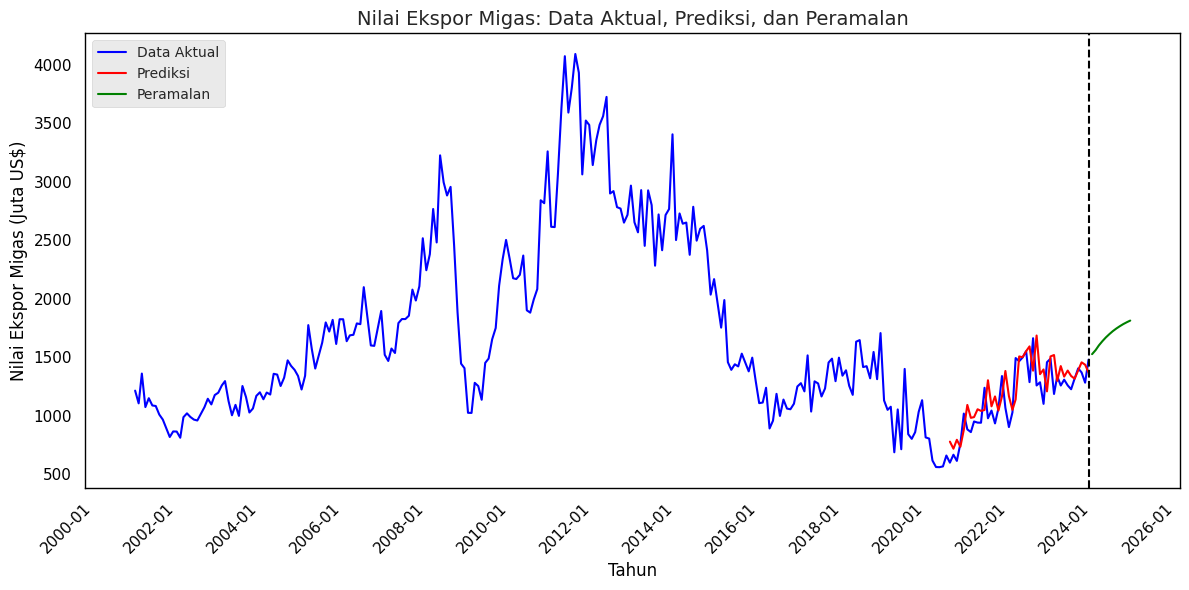

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [52]:
!pip install openpyxl

In [53]:
forecast_df.to_excel('forecast_data75_h2t3.xlsx', index=False)
from google.colab import files
files.download('forecast_data75_h2t3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_data75_h2t3.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_data75_h2t3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>